## Preparation
---

In [1]:
# https://www.youtube.com/watch?v=QIUxPv5PJOY

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt 

import yfinance as yf
import datetime


2023-09-18 01:15:26.403683: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Whole Price History
---
Observe the overall trend of Stock's closing price. <br>
If the price trend shows a clear upward/downward trend in a certain period (i.e has enough amount of historical data of a __Trend__ to train), it is considered as a __suitable target stock__.<br>
And then, we determine the appropriate range for the data set.

[*********************100%%**********************]  1 of 1 completed


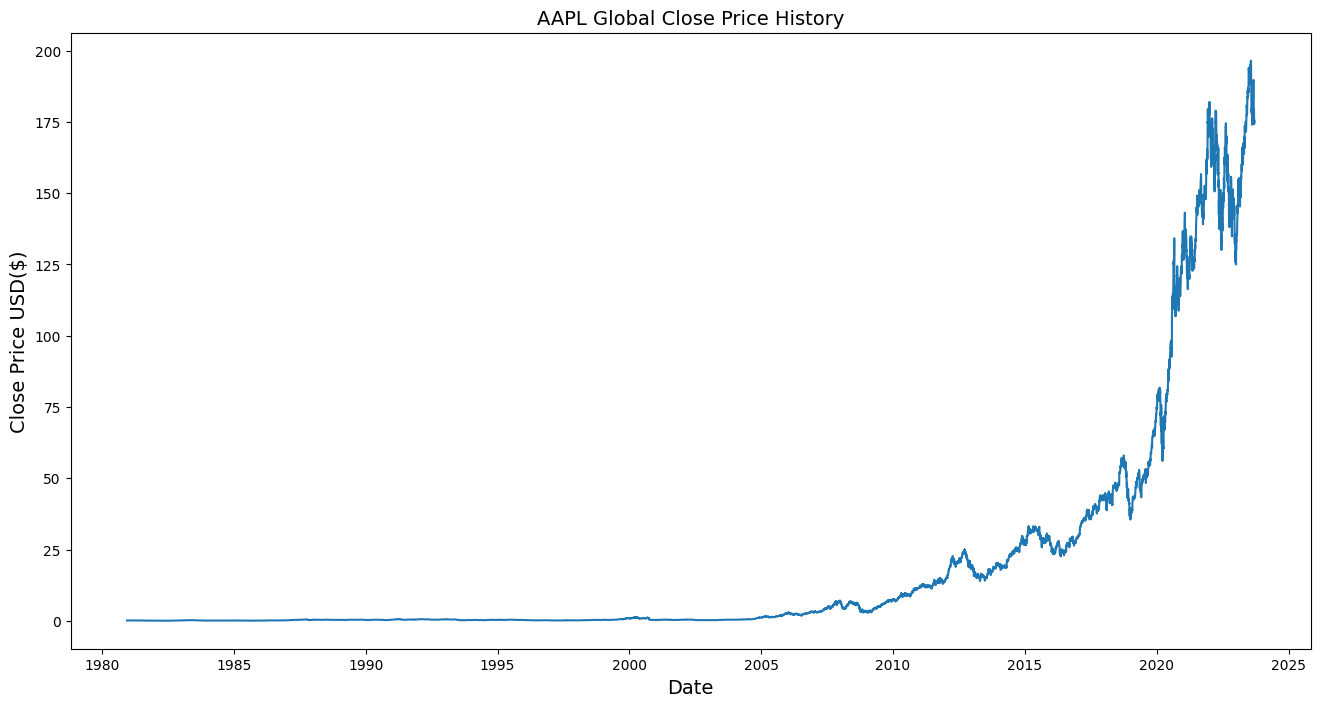

In [2]:
stock = "AAPL"
df = yf.download(stock)
plt.figure(figsize=(16,8))
plt.title(stock+' Global Close Price History', fontsize = 14)
plt.ylabel('Close Price USD($)', fontsize = 14)
plt.xlabel('Date',fontsize = 14)

plt.plot(df['Close'])
plt.show()

In [3]:
# Get the stock quote

start_date = datetime.datetime(2012, 1, 1)
# end_date = datetime.datetime(2019, 12, 17)

df = yf.download(stock, start=start_date)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.466094,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.533088,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.672229,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.804702,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.784392,394024400
...,...,...,...,...,...,...
2023-09-11,180.070007,180.300003,177.339996,179.360001,179.360001,58953100
2023-09-12,179.490005,180.130005,174.820007,176.300003,176.300003,90370200
2023-09-13,176.509995,177.300003,173.979996,174.210007,174.210007,84267900


## Selected range of Close Price History
___

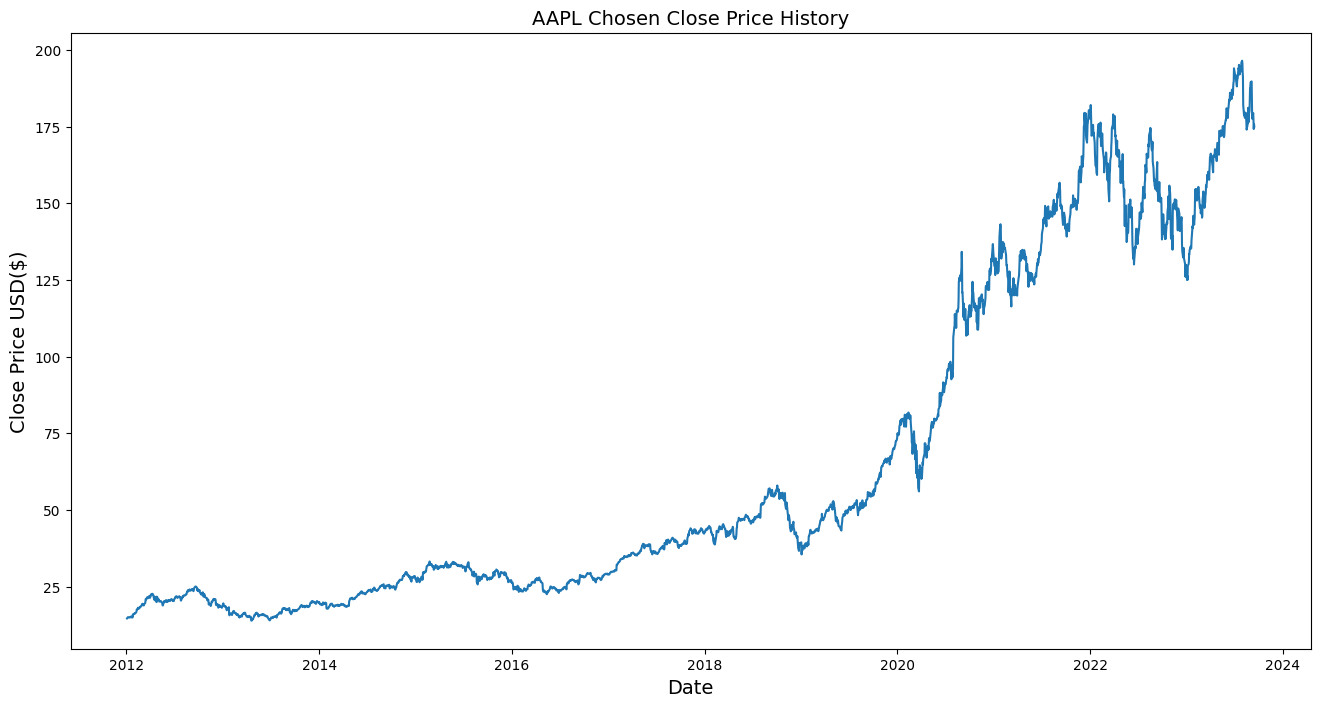

In [4]:
plt.figure(figsize=(16,8))
plt.title(stock+' Chosen Close Price History', fontsize = 14)
plt.ylabel('Close Price USD($)', fontsize = 14)
plt.xlabel('Date',fontsize = 14)

plt.plot(df['Close'])
plt.show()

## Data Processing
---

In [5]:
data = df[['Close']]
dataset = data.values  

## Get the length of training data 
training_data_len = math.ceil(len(dataset)*0.8)   ## Ratio of Train and Test set is 8:2
training_data_len

2356

In [6]:
## Scale the data by MinMax Method

scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_data = scaler.fit_transform(dataset)

In [7]:
## Hyperparameters for the training approach 

window_interval = 40  ## No. of historical records(days) for the closing price of a day
delay = 8  ## i.e. the No. of future days that we can do prediction

In [8]:
## Group the training_data of the designed value (i.e. window_interval)

train_data = scaled_data[0:training_data_len]  

x_train = []
y_train = []

for i in range(window_interval+delay, len(train_data)):
    x_train.append(train_data[i-window_interval-delay:i-delay,0])
    y_train.append(train_data[i,0])


In [9]:
## Convert the data type of x_train and y_train into Array

x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
## Reshape the data for LSTM model

i,j = x_train.shape
x_train_reshaped = np.reshape(x_train,(i,j,1))
x_train_reshaped.shape


(2308, 40, 1)

## Modeling
---

In [11]:
## Hyperparameters for the Model

num_cells_layer1 = 40
num_cells_layer2 = None
num_batch_size = 1
num_epochs = 3

In [12]:
## Build the LSTM Model

model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape= (j,1)))
model.add(LSTM(num_cells_layer1 , return_sequences=False, input_shape=(j,1)))

model.add(Dense(25))
model.add(Dense(1))

In [13]:
## Comple the model

model.compile(optimizer='adam', loss = 'mean_squared_error')

In [14]:
## Train the model

model.fit(x_train, y_train, batch_size = 1, epochs=num_epochs)

Epoch 1/3
2308/2308 [==============================] - 20s 8ms/step - loss: 8.2471e-04
Epoch 2/3
2308/2308 [==============================] - 17s 8ms/step - loss: 4.7540e-04
Epoch 3/3
2308/2308 [==============================] - 17s 7ms/step - loss: 4.5462e-04


In [15]:
test_data = scaled_data[training_data_len-window_interval:]

x_test = []
y_test = dataset[training_data_len:,]

for i in range (window_interval,len(test_data)):
    x_test.append(test_data[i-window_interval:i,0])


In [16]:
x_test = np.array(x_test)

In [17]:
x_test

array([[0.5840057 , 0.58104683, 0.59967672, ..., 0.61348478, 0.59627949,
        0.60833415],
       [0.58104683, 0.59967672, 0.59501926, ..., 0.59627949, 0.60833415,
        0.62192298],
       [0.59967672, 0.59501926, 0.58159476, ..., 0.60833415, 0.62192298,
        0.61545731],
       ...,
       [0.98509609, 0.99260289, 0.98180851, ..., 0.89989176, 0.90635747,
        0.88959059],
       [0.99260289, 0.98180851, 0.97528804, ..., 0.90635747, 0.88959059,
        0.87813871],
       [0.98180851, 0.97528804, 0.97972632, ..., 0.88959059, 0.87813871,
        0.88652215]])

In [18]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [19]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

19/19 [==============================] - 1s 4ms/step


## RMSE
---

In [20]:
rmse = np.sqrt(np.mean((y_test - predictions)**2))
rmse

7.376984668900627

## Plot the Data
---

/var/folders/0c/4yyxy27966j8h86h_vwsy3680000gn/T/ipykernel_20704/2834351389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


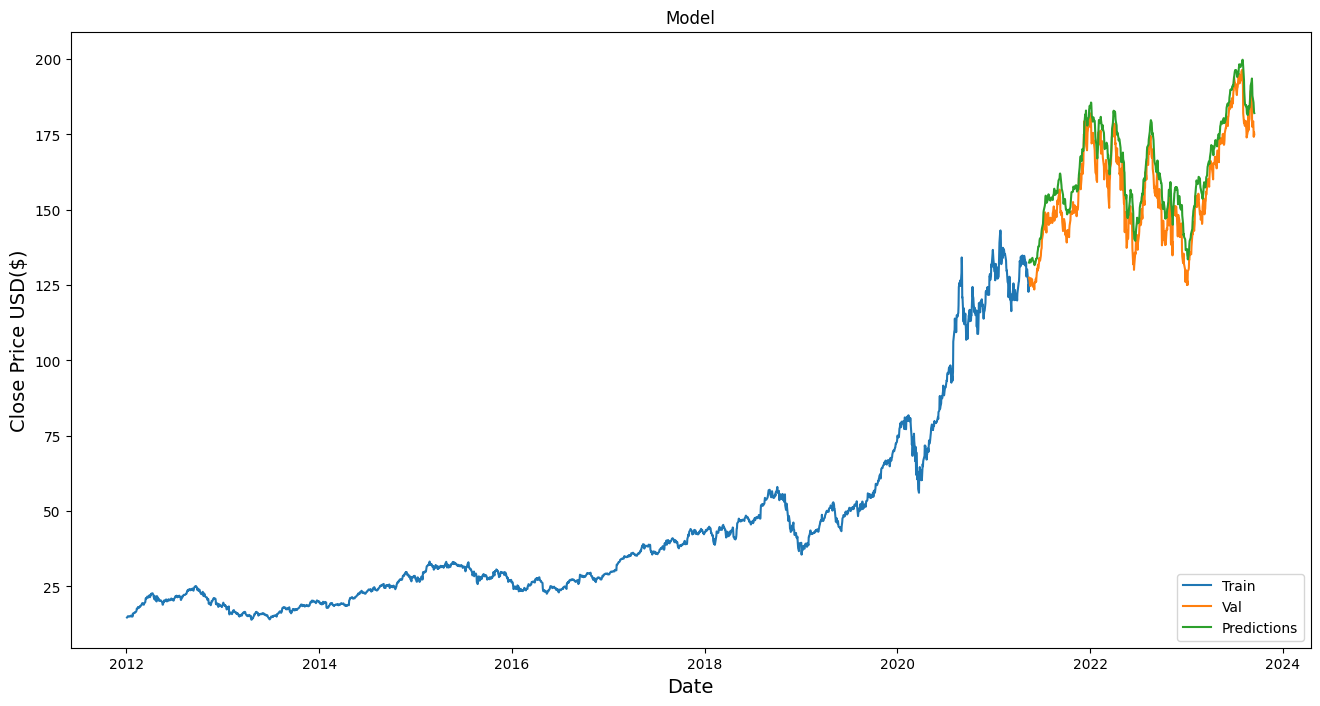

In [24]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize = (16,8))
plt.title('Model')
plt.xlabel('Date',fontsize = 14)
plt.ylabel('Close Price USD($)', fontsize = 14)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()




## Result in Error
---

In [22]:
valid

,Close,Predictions
Date,,
2021-05-14,127.449997,132.473892
2021-05-17,126.269997,133.408096
2021-05-18,124.849998,133.467163
2021-05-19,124.690002,132.917694
2021-05-20,127.309998,132.531891
...,...,...
2023-09-11,179.360001,186.144470
2023-09-12,176.300003,185.636215
2023-09-13,174.210007,184.078354


In [25]:
valid.append([2,2])
valid

AttributeError: 'DataFrame' object has no attribute 'append'

In [23]:
valid.to_csv('{0}days_{1}Cells_{2}Epoches_{3}daysdelay.csv'.format(window_interval,num_cells, num_epochs, delay), index=True)


NameError: name 'interval' is not defined

## Save the model
---

In [ ]:
# model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets
